### loading necessary libraries

In [1]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/FaceExpressions.zip', 'r') as zip_ref:
        zip_ref.extractall('')

!ls

for dirpath, dirnames, filenames in os.walk("/content/dataset"):
 print(f"There are {len(filenames)} images in '{dirpath}'.")

Mounted at /content/drive
data.csv  dataset  drive  sample_data
There are 0 images in '/content/dataset'.
There are 3740 images in '/content/dataset/Happy'.
There are 4027 images in '/content/dataset/Neutral'.
There are 1313 images in '/content/dataset/Angry'.
There are 1205 images in '/content/dataset/Ahegao'.
There are 1234 images in '/content/dataset/Surprise'.
There are 3934 images in '/content/dataset/Sad'.


In [2]:
for dirpath, dirnames, filenames in os.walk("/content/dataset"):
  print(f"There are {len(filenames)} images in '{dirpath}'.")

There are 0 images in '/content/dataset'.
There are 3740 images in '/content/dataset/Happy'.
There are 4027 images in '/content/dataset/Neutral'.
There are 1313 images in '/content/dataset/Angry'.
There are 1205 images in '/content/dataset/Ahegao'.
There are 1234 images in '/content/dataset/Surprise'.
There are 3934 images in '/content/dataset/Sad'.


## visualizing the images

In [3]:
def view_random_images(target_class, num_images=8):
  target_dir="/content/dataset"
  target_folder = os.path.join(target_dir, target_class)

  random_images = random.sample(os.listdir(target_folder), num_images)

  # Create a subplot to display multiple images
  plt.figure(figsize=(12, 6))
  for i, image in enumerate(random_images):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    img = mpimg.imread(os.path.join(target_folder, image))
    plt.imshow(img)
    plt.title(f"{target_class} - {i + 1}")
    plt.axis("off")

  plt.show()

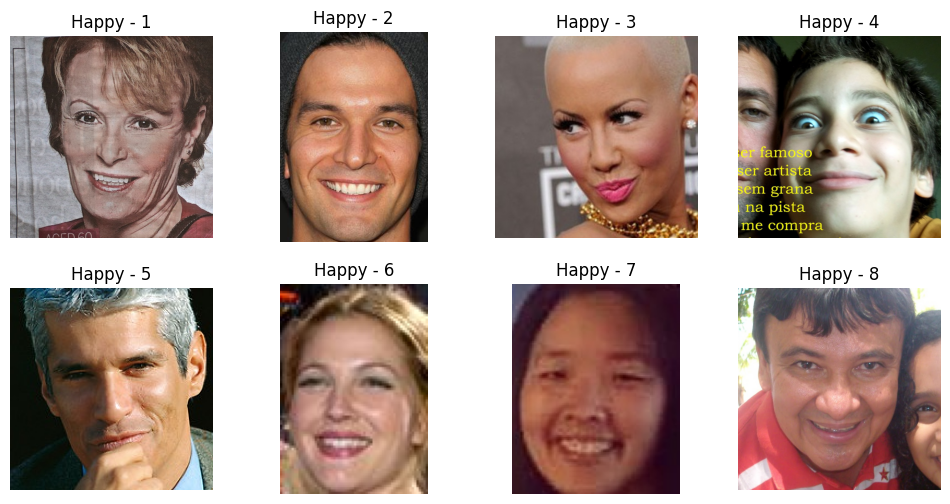

In [4]:
view_random_images("Happy",8)

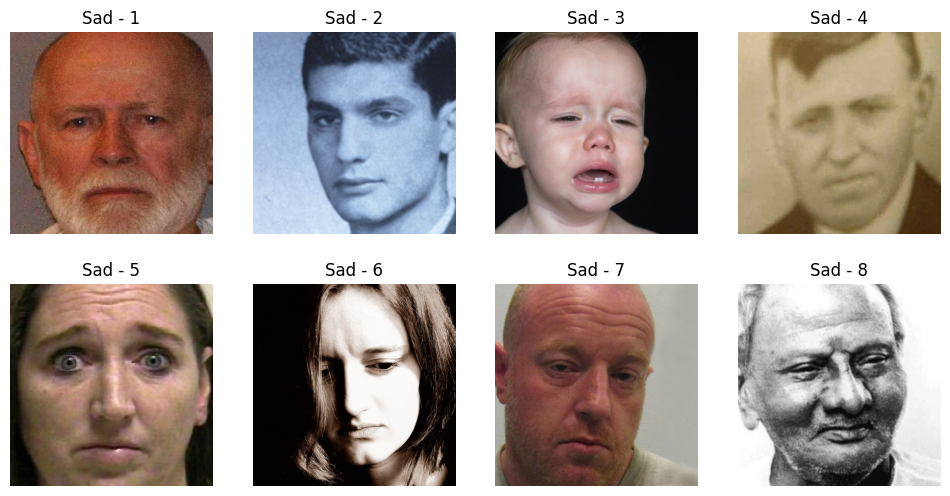

In [5]:
view_random_images("Sad",8)

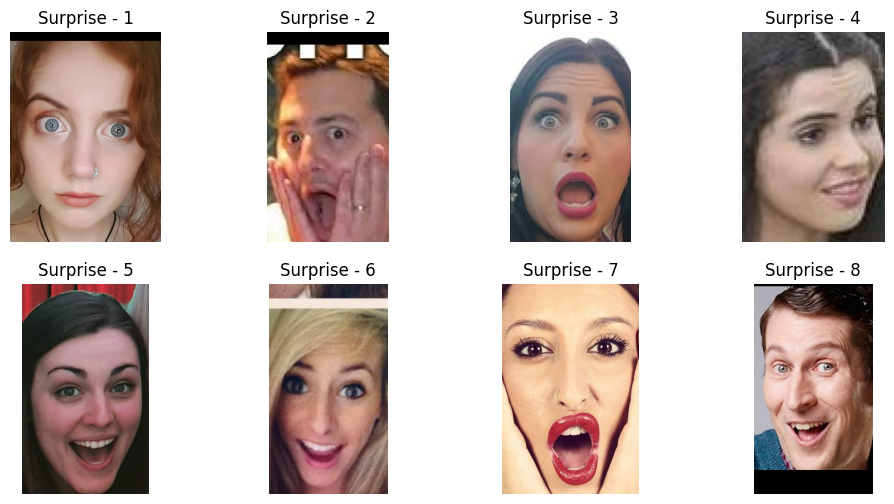

In [6]:
view_random_images("Surprise",8)

### Data preprocessing

In [8]:
data_dir='/content/dataset'
IMG_SIZE = (224, 224) # define image size
total_data= tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)


Found 15453 files belonging to 6 classes.


In [9]:
total_samples = total_data.cardinality().numpy()

train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Split the dataset
train_data = total_data.take(train_size)
test_data = total_data.skip(train_size)

print("Number of samples in training set:", train_size)
print("Number of samples in testing set:", test_size)

Number of samples in training set: 386
Number of samples in testing set: 97


In [10]:
total_data.class_names

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

### Creating Callbacks
* Tensorbord callback


In [11]:
checkpoint_path="Expresion/checkpoint.ckpt"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=True,
                                                          save_freq="epoch",
                                                          verbose=1)

In [12]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Mixed_precision
* speedup the training upto 3x
* one change we have to do is that in output layer we have to add dtype='float32'

In [13]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

### Data augmentaion sequencial layer

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # remove for EfficientNetB0
], name ="data_augmentation")

### First Model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
#x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(6, activation="softmax",dtype='float32', name="output_layer")(x)
#dtype='float32' because we are using mixpresion

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

258076736/258076736 [==============================] - 5s 0us/step


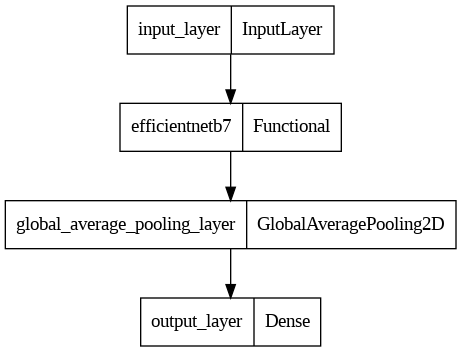

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model_1)


I tried but Augmentation Layer do not increse accuracy despite it decrease in my case,so i removed it

In [18]:
#complile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 2560)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 6)                 15366     
                                                                 
Total params: 64113053 (244.57 MB)
Trainable params: 15366 (60.02 KB)
Non-trainable params: 64097687 (244.51 MB)
______________

In [19]:
history_model_1_efficientB7 = model_1.fit(train_data,
                                           steps_per_epoch=len(train_data),
                                           epochs=10,
                                           batch_size=32,
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[checkpoint_callback] #out of memory page error happening after 4 to 5 epoch
                                       )


Epoch 1/10
386/386 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.5999
Epoch 1: val_loss improved from inf to 0.91513, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 176s 388ms/step - loss: 1.0439 - accuracy: 0.5999 - val_loss: 0.9151 - val_accuracy: 0.6475
Epoch 2/10
386/386 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.6635
Epoch 2: val_loss improved from 0.91513 to 0.85656, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 139s 359ms/step - loss: 0.8729 - accuracy: 0.6635 - val_loss: 0.8566 - val_accuracy: 0.6746
Epoch 3/10
386/386 [==============================] - ETA: 0s - loss: 0.8127 - accuracy: 0.6878
Epoch 3: val_loss improved from 0.85656 to 0.84528, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 139s 358ms/step - loss: 0.8127 - accuracy: 0.6878 - val_loss: 0.8453 - val_accuracy: 0.6727
Epoch 4/10
386/386 [=========

In [20]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

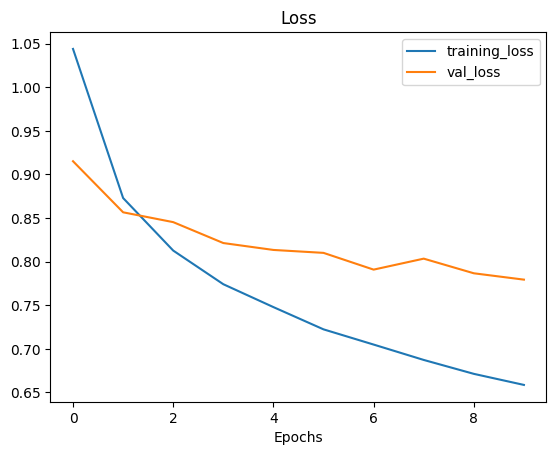

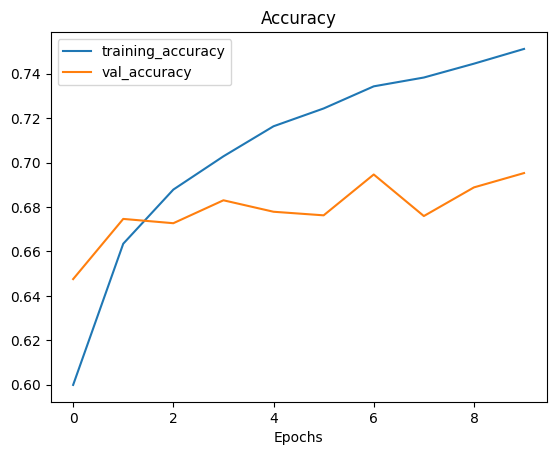

In [21]:
plot_loss_curves(history_model_1_efficientB7)

97/97 [==============================] - 65s 189ms/step


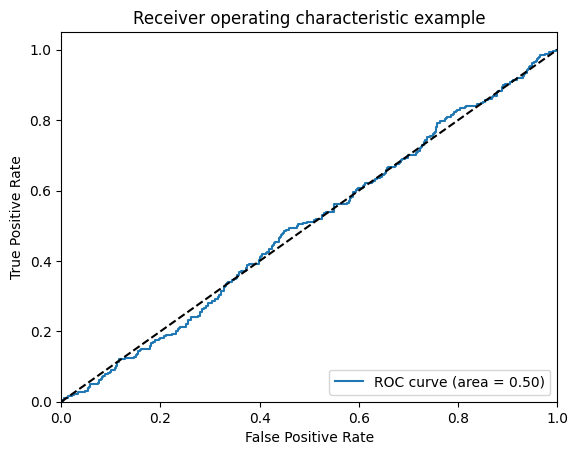

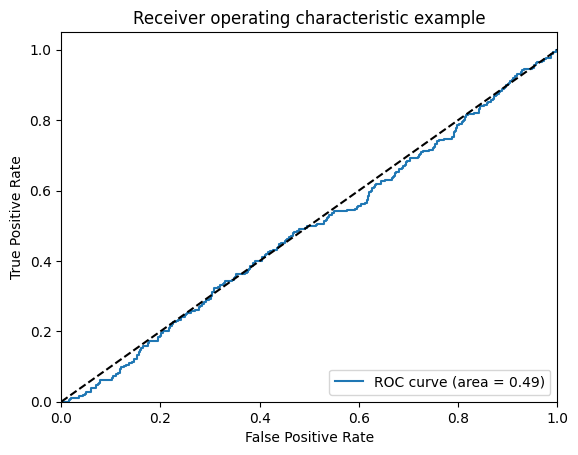

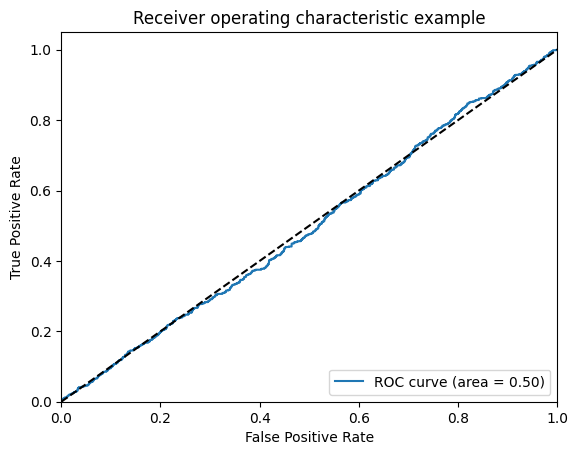

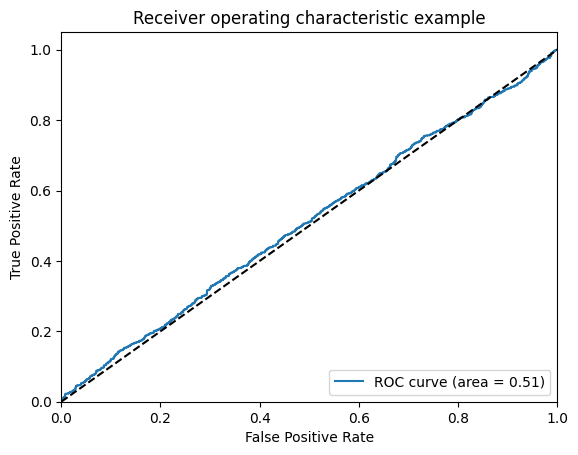

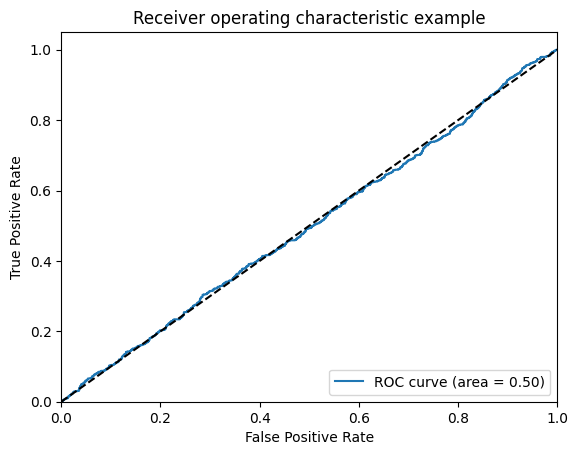

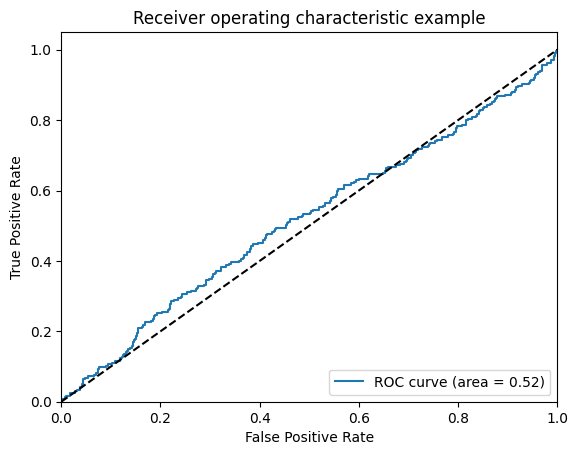

In [22]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is named 'model_1' and your test dataset is 'test_data'
# First, get the true labels and predictions
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = model_1.predict(test_data)

# Since your labels are one-hot encoded, you need to find the indices for the true labels
y_true = np.argmax(y_true, axis=1)

# Calculate ROC curve and ROC area for each class
n_classes = 6 # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=n_classes)[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


# Lets fine tune our model by unfreezing some of the layer

In [23]:
model_1.load_weights(checkpoint_path)

In [24]:
model_1.evaluate(test_data)

97/97 [==============================] - 60s 197ms/step - loss: 0.7768 - accuracy: 0.6956


[0.7768476605415344, 0.6955820918083191]

In [25]:
# Are these layers trainable?
for layer in model_1.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78ca38335720> True
<keras.src.engine.functional.Functional object at 0x78ca17743250> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x78ca38157bb0> True
<keras.src.layers.core.dense.Dense object at 0x78ca177637c0> True


In [26]:
# Access the base_model layers of model_1
model_1_base_model = model_1.layers[1]
model_1_base_model.name

'efficientnetb7'

In [27]:
# Make all the layers in model_1_base_model trainable
model_1_base_model.trainable = True

# Freeze all layers except for the last 15
for layer in model_1_base_model.layers[:-15]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])
print(len(model_1.trainable_variables))

15


In [28]:
# Fine-tune for another 10 epochs
initial_epoch=10
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_1 except with more trainable layers)
history_model_1_efficientB7_fineTune = model_1.fit(train_data,
                                                steps_per_epoch=len(train_data),
                                                epochs=fine_tune_epochs,
                                                batch_size=32,
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                initial_epoch=history_model_1_efficientB7.epoch[-1],# start from the previous last epoch
                                                callbacks=[checkpoint_callback]
                                                           )

Epoch 10/15
386/386 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.7486
Epoch 10: val_loss improved from 0.77934 to 0.71755, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 173s 384ms/step - loss: 0.6567 - accuracy: 0.7486 - val_loss: 0.7175 - val_accuracy: 0.7178
Epoch 11/15
386/386 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7956
Epoch 11: val_loss did not improve from 0.71755
386/386 [==============================] - 141s 362ms/step - loss: 0.5419 - accuracy: 0.7956 - val_loss: 0.7218 - val_accuracy: 0.7198
Epoch 12/15
386/386 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8316
Epoch 12: val_loss did not improve from 0.71755
386/386 [==============================] - 139s 360ms/step - loss: 0.4504 - accuracy: 0.8316 - val_loss: 0.7203 - val_accuracy: 0.7230
Epoch 13/15
386/386 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8695
Epoch 13: val_lo

In [29]:
model_1.load_weights(checkpoint_path)

In [35]:
model_1.save("model1.h5")

In [30]:
model_1.evaluate(test_data)

97/97 [==============================] - 60s 199ms/step - loss: 0.7126 - accuracy: 0.7356


[0.7126291394233704, 0.735569179058075]